# Quantitative Researcher Assignment - VNTrading
## Financial Time Series Analysis - Devanshu Sharma
- Problem Statement: Create a SMA crossover trading strategy for BTC data. Test the strategy using backtesting
- More details provided in the readme file

### Import standard libraries & Set up plotting styles
- Many extra libraries included since I preprocessed the notebook before receving the assignment

In [1]:
# Core data manipulation and numerical computing
import numpy as np
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Time series analysis
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import arch
import pandas_ta_classic as ta

# Machine learning and statistical models
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import xgboost as xgb
import lightgbm as lgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Financial specific
import yfinance as yf  # fallback for additional data if needed

# Performance optimization
from numba import jit
import multiprocessing as mp

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12# Set random seeds for reproducibility
np.random.seed(42)

### Data Extraction & Preprocessing

In [3]:
def load_data(csv_path=None, parquet_path=None):
    try:
        if parquet_path:
            df = pd.read_parquet(parquet_path)
            print("Loaded Parquet file")
        elif csv_path:
            df = pd.read_csv(csv_path)
            print("Loaded CSV file")
        else:
            raise ValueError("No file path provided")
            
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

# def preprocess_time_series(df, date_column=None, value_columns=None):
#     df_clean = df.copy()
    
#     # Set datetime index
#     if date_column:
#         df_clean[date_column] = pd.to_datetime(df_clean[date_column])
#         df_clean = df_clean.set_index(date_column)
#         df_clean = df_clean.sort_index()
#         print(f"Set datetime index: {date_column}")
    
#     # Handle missing values
#     initial_missing = df_clean.isnull().sum().sum()
#     if initial_missing > 0:
#         # For time series, use forward fill then backward fill
#         df_clean = df_clean.ffill().bfill()
#         remaining_missing = df_clean.isnull().sum().sum()
#         # print(f"Missing values removed: {initial_missing}")
    
#     # Remove constant columns
#     constant_columns = [col for col in df_clean.columns if df_clean[col].nunique() <= 1]
#     if constant_columns:
#         df_clean = df_clean.drop(columns=constant_columns)
#         # print(f"Removed constant columns: {constant_columns}")
    
#     return df_clean

### Print Data Summary & Statistics
- Preprocessing not needed as the data is clean and no null values
- Timestamp format in Unix with milliseconds units; convert properly into more intuitive format

In [4]:
df = load_data("BTCUSDT_price_data_2024-01-24.csv")
# df = preprocess_time_series(df, date_column="timestamp")

####
# Remove the trailing 'T', convert to integer, then to datetime
df['timestamp'] = df['timestamp'].str.replace('T', '').astype(np.int64)
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
# Remove the 'timestamp' column from the dataframe
df.drop(columns=['timestamp'], inplace=True)
###
# set as index for time-series convenience
df.set_index('datetime', inplace=True)
####

def data_overview(df):
    display(df.head())
    print(f"Shape: {df.shape}")
    print(df.info())
    print(df.describe())
    print("\nMissing values per column:")
    print(df.isnull().sum())

data_overview(df)

Loaded CSV file


,mid_price,volume
datetime,,
2024-01-24 00:00:00,39881.95,439.561
2024-01-24 00:01:00,39926.55,776.492
2024-01-24 00:02:00,39877.05,339.306
2024-01-24 00:03:00,39927.45,246.511
2024-01-24 00:04:00,39926.55,423.920


Shape: (1439, 2)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1439 entries, 2024-01-24 00:00:00 to 2024-01-24 23:58:00
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mid_price  1439 non-null   float64
 1   volume     1439 non-null   float64
dtypes: float64(2)
memory usage: 33.7 KB
None
          mid_price       volume
count   1439.000000  1439.000000
mean   39919.132279   189.511495
std      175.222416   223.523507
min    39516.950000    13.454000
25%    39777.600000    73.456500
50%    39917.850000   123.278000
75%    40047.700000   213.539500
max    40479.550000  2464.729000

Missing values per column:
mid_price    0
volume       0
dtype: int64


### Visualize the preprocessed data 

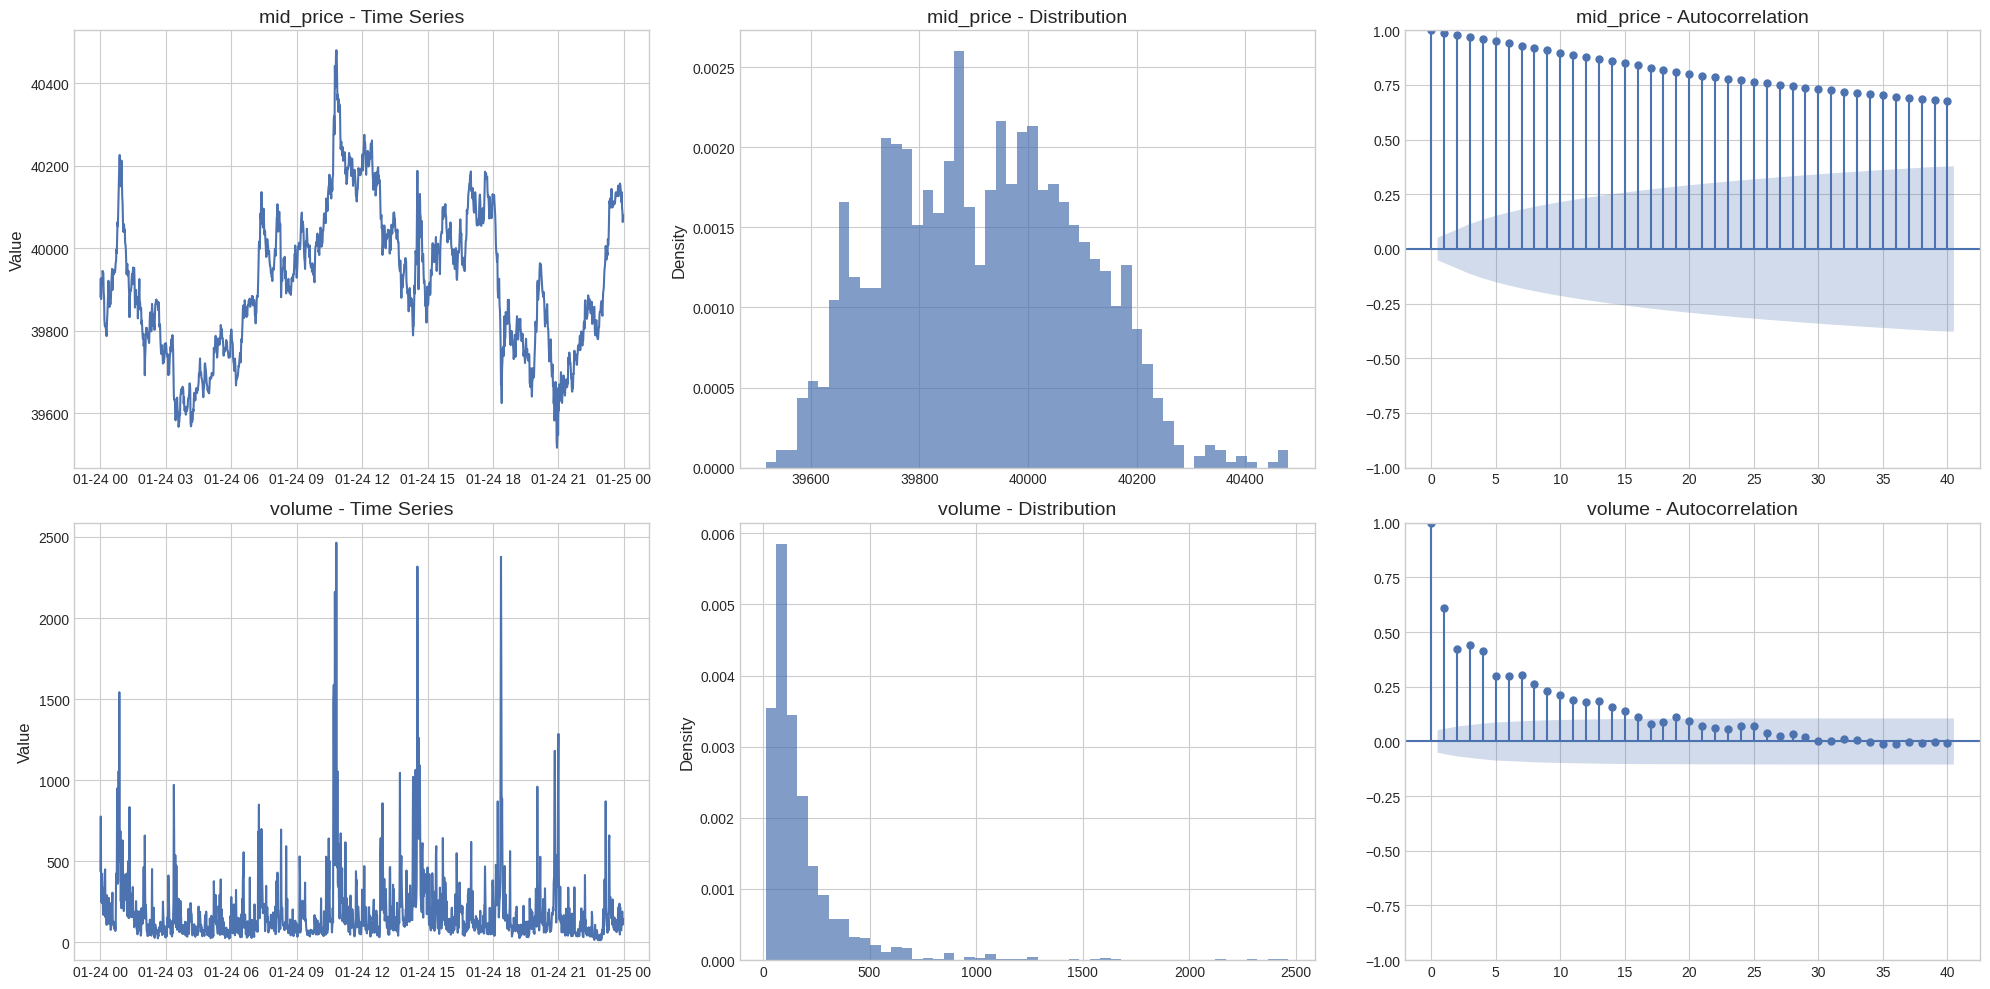

In [5]:
def plot_time_series_analysis(df, target_columns=None):

    if target_columns is None:
        target_columns = df.select_dtypes(include=[np.number]).columns[:3]  # First 3 numeric columns
    
    n_plots = len(target_columns)
    fig, axes = plt.subplots(n_plots, 3, figsize=(20, 5*n_plots))
    
    if n_plots == 1:
        axes = axes.reshape(1, -1)
    
    for i, col in enumerate(target_columns):
        # Time series plot
        axes[i, 0].plot(df.index, df[col])
        axes[i, 0].set_title(f'{col} - Time Series')
        axes[i, 0].set_ylabel('Value')
        axes[i, 0].grid(True)
        
        # Distribution
        axes[i, 1].hist(df[col].dropna(), bins=50, alpha=0.7, density=True)
        axes[i, 1].set_title(f'{col} - Distribution')
        axes[i, 1].set_ylabel('Density')
        
        # ACF plot
        plot_acf(df[col].dropna(), ax=axes[i, 2], lags=40)
        axes[i, 2].set_title(f'{col} - Autocorrelation')
    
    plt.tight_layout()
    # plt.savefig("preprocessed_data_visuals.pdf", format="pdf", dpi=300)
    plt.show()

def correlation_analysis(df):
    numeric_df = df.select_dtypes(include=[np.number])
    
    plt.figure(figsize=(15, 10))
    
    # Correlation heatmap
    corr_matrix = numeric_df.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix Heatmap')
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

plot_time_series_analysis(df)
# correlation_analysis(df)

### Feature Engineering & Feature Selection
- Create Features 
- Select the most relevant features to train the model

In [6]:
#uncomment for more robust analysis but first perform the minimal asked analysis
# def create_features(df, price_column=None):
#     df_features = df.copy()
    
#     numeric_columns = df_features.select_dtypes(include=[np.number]).columns
    
#     for col in numeric_columns:
#         # Returns
#         df_features[f'{col}_returns'] = df_features[col].pct_change()
#         # df_features[f'{col}_log_returns'] = np.log(df_features[col] / df_features[col].shift(1))
        
#         # Rolling statistics
#         for window in [5, 10, 20]:  # Common financial windows
#             df_features[f'{col}_rolling_mean_{window}'] = df_features[col].rolling(window=window).mean()
#             df_features[f'{col}_rolling_std_{window}'] = df_features[col].rolling(window=window).std()
#             df_features[f'{col}_rolling_min_{window}'] = df_features[col].rolling(window=window).min()
#             df_features[f'{col}_rolling_max_{window}'] = df_features[col].rolling(window=window).max()
            
#             # Volatility (annualized if daily data)
#             df_features[f'{col}_volatility_{window}'] = df_features[col].rolling(window=window).std() * np.sqrt(252)
        
#         # Technical indicators
#         df_features[f'{col}_momentum'] = df_features[col] / df_features[col].shift(5) - 1
#         df_features[f'{col}_MA_ratio'] = df_features[col] / df_features[f'{col}_rolling_mean_20']
        
#         # Statistical features
#         df_features[f'{col}_zscore'] = (df_features[col] - df_features[col].mean()) / df_features[col].std()
    
#     # Handle infinite values and NaNs created by transformations
#     df_features = df_features.replace([np.inf, -np.inf], np.nan)
#     df_features = df_features.ffill().bfill()
    
#     print(f" Created {len(df_features.columns) - len(df.columns)} additional features")
#     return df_features

def create_features(df, sma_period = 18):
    df_indicators = df.copy()
    # Calculate 1-minute returns
    df_indicators['returns'] = df_indicators['mid_price'].pct_change()
    
    # Calculate n-period Simple Moving Average (SMA)
    df_indicators['sma'] = df_indicators['mid_price'].rolling(window=sma_period).mean()
    
    # Calculate additional useful metrics for analysis
    df_indicators['price_sma_diff'] = df_indicators['mid_price'] - df_indicators['sma']
    df_indicators['price_sma_ratio'] = df_indicators['mid_price'] / df_indicators['sma']

    
    return df_indicators

# select only the relevant features
def select_features(df, ticker):
    features = df[ticker].dropna()
    return features

all_features = create_features(df)

# Add more tickers if needed
selected_tickers = ["returns", "sma"]
selected_features = select_features(all_features, selected_tickers)
df = pd.concat([df,selected_features], ignore_index=True)

# Handle infinite values and NaNs created by transformations
df = df.replace([np.inf, -np.inf], np.nan)
df = df.ffill().bfill()

In [7]:
df

,mid_price,volume,returns,sma
0,39881.95,439.561,-0.000254,39872.366667
1,39926.55,776.492,-0.000254,39872.366667
2,39877.05,339.306,-0.000254,39872.366667
3,39927.45,246.511,-0.000254,39872.366667
4,39926.55,423.920,-0.000254,39872.366667
...,...,...,...,...
2856,40079.55,144.008,0.000601,40137.330556
2857,40079.55,144.008,-0.000947,40135.480556
2858,40079.55,144.008,-0.000244,40132.869444
2859,40079.55,144.008,-0.000619,40129.347222


### Generate signals for buy-sell calls

In [9]:
def generate_trading_signals(df_indicators):
    df_signals = df_indicators.copy()
    
    # Initialize signal columns
    df_signals['signal'] = 0  # 0 = no signal, 1 = buy, -1 = sell
    df_signals['position'] = 0  # 1 = long, -1 = short, 0 = flat
    df_signals['crossover'] = 0  # Track crossover events
    
    # Detect crossovers using price-SMA difference sign changes
    
    # Calculate the difference and its sign
    df_signals['price_sma_diff'] = df_signals['mid_price'] - df_signals['sma']
    df_signals['prev_price_sma_diff'] = df_signals['price_sma_diff'].shift(1)
    
    # Detect crossovers: sign change from negative to positive (price crosses above SMA)
    buy_condition = (df_signals['prev_price_sma_diff'] < 0) & (df_signals['price_sma_diff'] > 0)
    
    # Detect crossunders: sign change from positive to negative (price crosses below SMA)  
    sell_condition = (df_signals['prev_price_sma_diff'] > 0) & (df_signals['price_sma_diff'] < 0)
    
    # Apply signals
    df_signals.loc[buy_condition, 'signal'] = 1    # Buy signal
    df_signals.loc[sell_condition, 'signal'] = -1  # Sell signal
    df_signals.loc[buy_condition | sell_condition, 'crossover'] = 1

    # # Handle infinite values and NaNs created by transformations
    # df_signals = df_signals.replace([np.inf, -np.inf], np.nan)
    # df_signals = df_signals.ffill().bfill()
    
    return df_signals

# df_signals = generate_trading_signals(df)
df = generate_trading_signals(df)

In [10]:
df

,mid_price,volume,returns,sma,signal,position,crossover,price_sma_diff,prev_price_sma_diff
0,39881.95,439.561,-0.000254,39872.366667,0,0,0,9.583333,NaN
1,39926.55,776.492,-0.000254,39872.366667,0,0,0,54.183333,9.583333
2,39877.05,339.306,-0.000254,39872.366667,0,0,0,4.683333,54.183333
3,39927.45,246.511,-0.000254,39872.366667,0,0,0,55.083333,4.683333
4,39926.55,423.920,-0.000254,39872.366667,0,0,0,54.183333,55.083333
...,...,...,...,...,...,...,...,...,...
2856,40079.55,144.008,0.000601,40137.330556,0,0,0,-57.780556,-56.547222
2857,40079.55,144.008,-0.000947,40135.480556,0,0,0,-55.930556,-57.780556
2858,40079.55,144.008,-0.000244,40132.869444,0,0,0,-53.319444,-55.930556
2859,40079.55,144.008,-0.000619,40129.347222,0,0,0,-49.797222,-53.319444


### Simulate Positions

In [11]:
def simulate_positions(df_signals):
    df_positions = df_signals.copy()
    
    # Initialize tracking
    current_position = 0  # Start flat
    positions = []
    
    print("Simulating position changes")
    
    for i in range(len(df_positions)):
        signal = df_positions['signal'].iloc[i]
        
        # Only change position when we get an opposite signal
        if signal != 0:
            if current_position <= 0 and signal == 1:  # From short/flat to long
                new_position = 1
            elif current_position >= 0 and signal == -1:  # From long/flat to short  
                new_position = -1
            else:
                new_position = current_position  # Same signal, no change
        else:
            new_position = current_position  # No signal, maintain position
        
        positions.append(new_position)
        current_position = new_position
    
    # Assign the positions to the dataframe
    df_positions['position'] = positions
    
    # Count position changes
    position_changes = (df_positions['position'] != df_positions['position'].shift(1)).sum() - 1  # Subtract initial
    
    return df_positions

df_positions = simulate_positions(df)

Simulating position changes


### Backtesting the strategy


In [12]:
def run_backtest(df_positions, initial_capital=100000):

    df_backtest = df_positions.copy()
    
    # Calculate period returns based on position direction
    # Long position: gain when price goes up, lose when price goes down
    # Short position: gain when price goes down, lose when price goes up
    df_backtest['period_return'] = df_backtest['position'] * df_backtest['returns']
    
    # Calculate cumulative returns and equity curve
    df_backtest['cumulative_return'] = (1 + df_backtest['period_return']).cumprod()
    df_backtest['equity'] = initial_capital * df_backtest['cumulative_return']
    
    # Calculate running maximum for drawdown calculation
    df_backtest['equity_peak'] = df_backtest['equity'].expanding().max()
    df_backtest['drawdown'] = (df_backtest['equity_peak'] - df_backtest['equity']) / df_backtest['equity_peak']
    
    return df_backtest

df_backtest = run_backtest(df_positions)

In [13]:
df_backtest

,mid_price,volume,returns,sma,signal,position,crossover,price_sma_diff,prev_price_sma_diff,period_return,cumulative_return,equity,equity_peak,drawdown
0,39881.95,439.561,-0.000254,39872.366667,0,0,0,9.583333,NaN,-0.000000,1.000000,100000.000000,100000.000000,0.000000
1,39926.55,776.492,-0.000254,39872.366667,0,0,0,54.183333,9.583333,-0.000000,1.000000,100000.000000,100000.000000,0.000000
2,39877.05,339.306,-0.000254,39872.366667,0,0,0,4.683333,54.183333,-0.000000,1.000000,100000.000000,100000.000000,0.000000
3,39927.45,246.511,-0.000254,39872.366667,0,0,0,55.083333,4.683333,-0.000000,1.000000,100000.000000,100000.000000,0.000000
4,39926.55,423.920,-0.000254,39872.366667,0,0,0,54.183333,55.083333,-0.000000,1.000000,100000.000000,100000.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,40079.55,144.008,0.000601,40137.330556,0,-1,0,-57.780556,-56.547222,-0.000601,0.975989,97598.870351,106359.687614,0.082370
2857,40079.55,144.008,-0.000947,40135.480556,0,-1,0,-55.930556,-57.780556,0.000947,0.976913,97691.274757,106359.687614,0.081501
2858,40079.55,144.008,-0.000244,40132.869444,0,-1,0,-53.319444,-55.930556,0.000244,0.977152,97715.150534,106359.687614,0.081276
2859,40079.55,144.008,-0.000619,40129.347222,0,-1,0,-49.797222,-53.319444,0.000619,0.977756,97775.600409,106359.687614,0.080708


### Performance Metrics
- Sharpe ratio > 3 is nice
- Max drawdown ~ 46 percent shows balanced strategy

In [14]:
def calculate_performance_metrics(df_backtest, initial_capital=100000):
    # Remove rows with NaN (first few periods without returns)
    df_valid = df_backtest.dropna(subset=['period_return'])
    
    if len(df_valid) == 0:
        print(" No valid data for performance calculation")
        return {}
    
    # Total return
    final_equity = df_valid['equity'].iloc[-1]
    total_return_pct = (final_equity - initial_capital) / initial_capital * 100
    
    # Number of trades (count position changes, excluding the initial position)
    position_changes = (df_valid['position'] != df_valid['position'].shift(1)).sum()
    num_trades = max(0, position_changes - 1)  # Subtract initial position setting
    
    # Maximum drawdown
    max_drawdown_pct = df_valid['drawdown'].max() * 100
    
    # Sharpe ratio (annualized, assuming 1-minute data)
    # There are ~252*6.5*60 = 98,280 trading minutes in a year
    annualization_factor = np.sqrt(252 * 6.5 * 60)  # For 1-minute data
    excess_returns = df_valid['period_return']  # Assuming risk-free rate = 0 for simplicity
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * annualization_factor
    
    metrics = {
        'Total Return (%)': total_return_pct,
        'Number of Trades': num_trades,
        'Maximum Drawdown (%)': max_drawdown_pct,
        'Sharpe Ratio': sharpe_ratio,
        'Final Equity ($)': final_equity,
        'Initial Capital ($)': initial_capital
    }
    
    return metrics

metrics = calculate_performance_metrics(df_backtest)

In [15]:
metrics

{'Total Return (%)': -2.263447793812098,
 'Number of Trades': 65,
 'Maximum Drawdown (%)': 14.864124959507539,
 'Sharpe Ratio': -5.2292210388480775,
 'Final Equity ($)': 97736.5522061879,
 'Initial Capital ($)': 100000}

### Plot the Equity (PnL curves) 

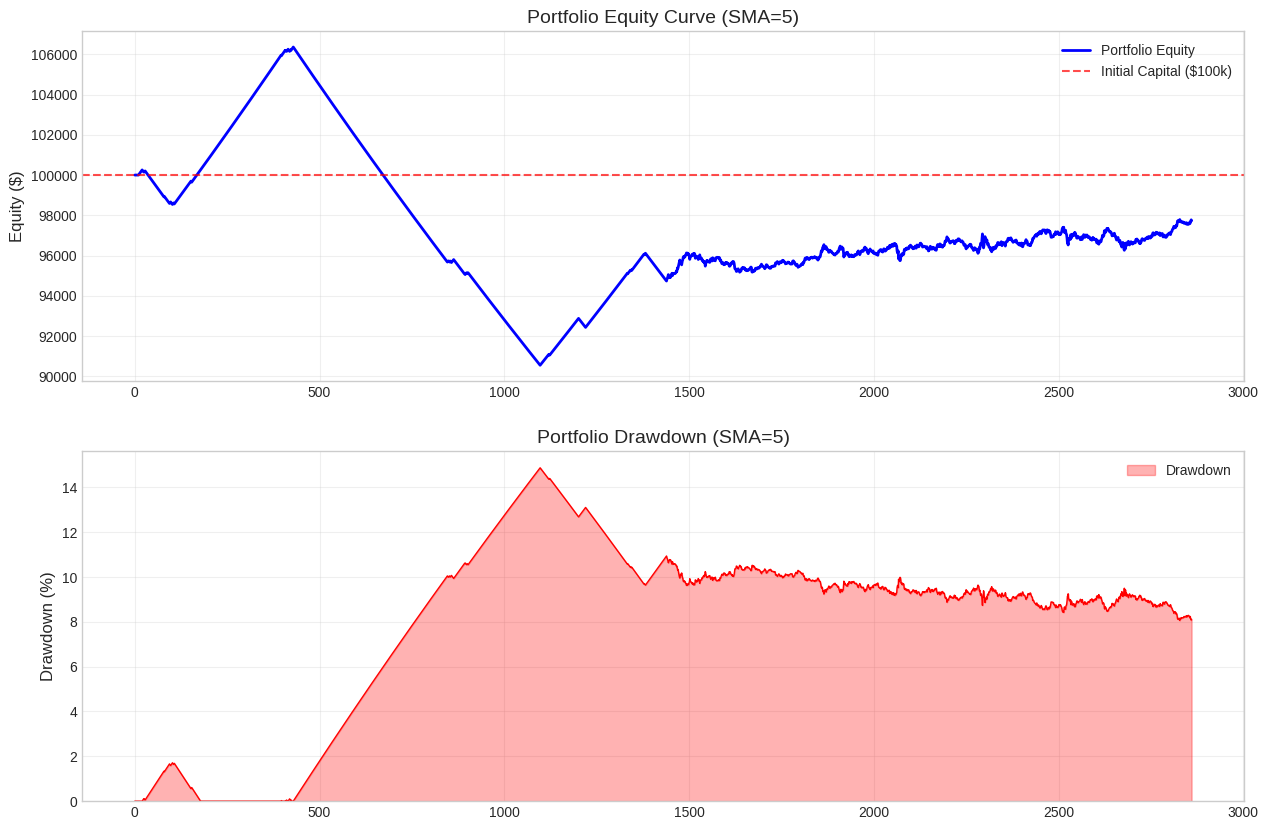

In [16]:
def plot_backtest_results(df_backtest):

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Plot 1: Equity curve
    ax1.plot(df_backtest.index, df_backtest['equity'], linewidth=2, color='blue', label='Portfolio Equity')
    ax1.axhline(y=100000, color='red', linestyle='--', alpha=0.7, label='Initial Capital ($100k)')
    ax1.set_title('Portfolio Equity Curve (SMA=5)')
    ax1.set_ylabel('Equity ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Drawdown
    ax2.fill_between(df_backtest.index, 0, df_backtest['drawdown'] * 100, 
                    color='red', alpha=0.3, label='Drawdown')
    ax2.plot(df_backtest.index, df_backtest['drawdown'] * 100, color='red', linewidth=1)
    ax2.set_title('Portfolio Drawdown (SMA=5)')
    ax2.set_ylabel('Drawdown (%)')
    ax2.set_ylim(bottom=0)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # plt.tight_layout()
    # plt.savefig("equity_curve_SMA5.pdf", format="pdf", dpi=300)
    # plt.show()
plot_backtest_results(df_backtest)

### Grid Search for optimal SMA Window

In [18]:
df = load_data("BTCUSDT_price_data_2024-01-24.csv")
# df = preprocess_time_series(df, date_column="timestamp")

####
# Remove the trailing 'T', convert to integer, then to datetime
df['timestamp'] = df['timestamp'].str.replace('T', '').astype(np.int64)
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
# Remove the 'timestamp' column from the dataframe
df.drop(columns=['timestamp'], inplace=True)
###
# set as index for time-series convenience
df.set_index('datetime', inplace=True)
####

def optimize_sma_parameter(df, sma_periods=[5, 10, 15, 20, 25], initial_capital=100000):

    results = []
    
    for period in sma_periods:
        # Recalculate indicators with current period
        all_features = create_features(df, sma_period=period)
        selected_tickers = ["returns", "sma"]
        selected_features = select_features(all_features, selected_tickers)
        df_indicators = pd.concat([df,selected_features], ignore_index=True)
        
        # Handle infinite values and NaNs created by transformations
        df_indicators = df_indicators.replace([np.inf, -np.inf], np.nan)
        df_indicators = df_indicators.ffill().bfill()
        df_signals = generate_trading_signals(df_indicators)
        df_positions = simulate_positions(df_signals)
        df_backtest = run_backtest(df_positions, initial_capital)
        metrics = calculate_performance_metrics(df_backtest)
        
        results.append({
            'sma_period': period,
            'total_return': metrics['Total Return (%)'],
            'num_trades': metrics['Number of Trades'], 
            'max_drawdown': metrics['Maximum Drawdown (%)'],
            'sharpe_ratio': metrics['Sharpe Ratio'],
            'final_equity': metrics['Final Equity ($)']
        })
    
    results_df = pd.DataFrame(results)
    return results_df.sort_values('total_return', ascending=False)

# Run optimization
optimization_results = optimize_sma_parameter(df)
print(optimization_results)

Loaded CSV file
Simulating position changes
Simulating position changes
Simulating position changes
Simulating position changes
Simulating position changes
   sma_period  total_return  num_trades  max_drawdown  sharpe_ratio  \
3          20     14.521070          71     11.186837     28.485455   
1          10      2.609582          62     47.223692      3.113534   
0           5      2.026255          64      1.362997      5.054735   
2          15      0.505982          50     10.380503      1.283040   
4          25      0.272584          63      7.785734      0.739768   

    final_equity  
3  114521.069750  
1  102609.582109  
0  102026.254822  
2  100505.981895  
4  100272.583582  


### Optional Tasks: Transaction Fees

In [18]:
def run_backtest_with_transaction_fee(df_positions, initial_capital=100000, transaction_cost=0.0002):
    
    df_backtest = df_positions.copy()
    
    # Calculate period returns based on position direction
    df_backtest['period_return'] = df_backtest['position'] * df_backtest['returns']
    
    # Track position changes for transaction cost calculation
    df_backtest['position_change'] = (df_backtest['position'] != df_backtest['position'].shift(1)).astype(int)
    
    # Calculate cumulative returns before costs
    df_backtest['cumulative_return_before_costs'] = (1 + df_backtest['period_return']).cumprod()
    df_backtest['equity_before_costs'] = initial_capital * df_backtest['cumulative_return_before_costs']
    
    # Apply transaction costs
    # Each position change incurs 0.02% cost on the current equity
    cost_factor = 1 - transaction_cost
    df_backtest['cost_multiplier'] = 1.0
    df_backtest.loc[df_backtest['position_change'] == 1, 'cost_multiplier'] = cost_factor
    
    # Calculate cumulative cost impact
    df_backtest['cumulative_cost'] = df_backtest['cost_multiplier'].cumprod()
    
    # Final equity
    df_backtest['equity'] = df_backtest['equity_before_costs'] * df_backtest['cumulative_cost']
    df_backtest['cumulative_return'] = df_backtest['equity'] / initial_capital
    
    # Calculate running maximum for drawdown calculation
    df_backtest['equity_peak'] = df_backtest['equity'].expanding().max()
    df_backtest['drawdown'] = (df_backtest['equity_peak'] - df_backtest['equity']) / df_backtest['equity_peak']
    
    # Calculate total transaction costs paid
    total_trades = df_backtest['position_change'].sum() - 1  # Subtract initial position
    total_cost_amount = initial_capital - (initial_capital * (cost_factor ** total_trades))
    
    print(f"Transaction cost: {transaction_cost*100}% per trade")
    print(f"Total trades with costs: {total_trades}")
    print(f"Total transaction costs: ${total_cost_amount:.2f}")
    
    return df_backtest

df_backtest_with_transaction_fee = run_backtest_with_transaction_fee(df_positions)

def calculate_performance_metrics_with_transaction_fee(df_backtest, initial_capital=100000):
    df_valid = df_backtest.dropna(subset=['period_return'])
        
    # Total return with costs
    final_equity = df_valid['equity'].iloc[-1]
    total_return_pct = (final_equity - initial_capital) / initial_capital * 100
    
    # Total return without costs for comparison
    final_equity_no_costs = df_valid['equity_before_costs'].iloc[-1]
    total_return_no_costs_pct = (final_equity_no_costs - initial_capital) / initial_capital * 100
    
    # Number of trades (count position changes, excluding the initial position)
    position_changes = df_valid['position_change'].sum()
    num_trades = max(0, position_changes - 1)
    
    # Maximum drawdown
    max_drawdown_pct = df_valid['drawdown'].max() * 100
    
    # Sharpe ratio (annualized)
    annualization_factor = np.sqrt(252 * 6.5 * 60)
    excess_returns = df_valid['period_return']
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * annualization_factor
    
    # Cost impact analysis
    cost_impact_pct = total_return_no_costs_pct - total_return_pct
    total_costs_paid = initial_capital - (initial_capital * (0.9998 ** num_trades))
    
    metrics = {
        'Total Return (%)': total_return_pct,
        'Total Return (No Costs) (%)': total_return_no_costs_pct,
        'Cost Impact (%)': cost_impact_pct,
        'Number of Trades': num_trades,
        'Transaction Cost per Trade (%)': 0.02,
        'Total Costs Paid ($)': total_costs_paid,
        'Maximum Drawdown (%)': max_drawdown_pct,
        'Sharpe Ratio': sharpe_ratio,
        'Final Equity ($)': final_equity,
        'Final Equity (No Costs) ($)': final_equity_no_costs,
        'Initial Capital ($)': initial_capital
    }
    
    return metrics

metrics = calculate_performance_metrics_with_transaction_fee(df_backtest_with_transaction_fee)
metrics

Transaction cost: 0.02% per trade
Total trades with costs: 62
Total transaction costs: $1232.47


{'Total Return (%)': 1.324684734605471,
 'Total Return (No Costs) (%)': 2.609582108892777,
 'Cost Impact (%)': 1.284897374287306,
 'Number of Trades': 62,
 'Transaction Cost per Trade (%)': 0.02,
 'Total Costs Paid ($)': 1232.4661669513443,
 'Maximum Drawdown (%)': 47.44490982583013,
 'Sharpe Ratio': 3.1135338011967204,
 'Final Equity ($)': 101324.68473460547,
 'Final Equity (No Costs) ($)': 102609.58210889278,
 'Initial Capital ($)': 100000}

## The task completes here
## Below code I wrote with estimation before getting the problem

## Less Relevant Code

### Setup the forecasting model
- Multiple choices provided
- Select the best one according to the time constraints and underlying data
- Comment out the useless models to save time

In [ ]:
def train_test_models(self, X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        # 'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(random_state=42)
        # 'LightGBM': lgb.LGBMRegressor(random_state=42)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        model.fit(X_train, y_train)
        
        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_mae = mean_absolute_error(y_test, y_pred_test)
        test_r2 = r2_score(y_test, y_pred_test)
        
        results[name] = {
            'model': model,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_r2': test_r2,
            'predictions': y_pred_test
        }
        
        print(f"{name} - Test RMSE: {test_rmse:.6f}, R²: {test_r2:.6f}")
    
    return results

### Saving the results externally

In [ ]:
def save_results(results_dict, filename_prefix='DevanshuSharma_VNTrading_results'):
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    
    for name, result in results_dict.items():
        if isinstance(result, pd.DataFrame):
            result.to_csv(f'{filename_prefix}_{name}_{timestamp}.csv', index=False)
        elif isinstance(result, plt.Figure):
            result.savefig(f'{filename_prefix}_{name}_{timestamp}.png', dpi=300, bbox_inches='tight')
    
    print(f"Saved externally as: {filename_prefix}")

### (Optional) Interactive Plots

In [ ]:
def plot_interactive_time_series(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns.tolist()
    
    fig = go.Figure()
    
    for col in columns:
        fig.add_trace(go.Scatter(
            x=df.index,
            y=df[col],
            name=col,
            mode='lines'
        ))
    
    fig.update_layout(
        title="Time Series Analysis",
        xaxis_title="Date",
        yaxis_title="Value",
        hovermode='x unified',
        height=500
    )
    
    fig.show()

plot_interactive_time_series(df)

### Check stationarity of the time series data
- A time series data needs to be stationary in order for ARIMA model to work
- There are no such restrictions for SARIMA / SARIMAX models or Machine Learning Models
- However, it's a good practice to check for the stationarity of a time series data
- Determined with ADF test: if the p-value < 0.05, you reject the null hypothesis (that the series is non-stationary)

In [ ]:
def stationarity_analysis(df, columns=None):
    if columns is None:
        columns = df.select_dtypes(include=[np.number]).columns
    
    results = []
    
    for col in columns:
        series = df[col].dropna()
        
        # Augmented Dickey-Fuller test
        adf_result = adfuller(series)
        adf_stat, adf_pvalue = adf_result[0], adf_result[1]
        
        # KPSS test
        try:
            kpss_result = kpss(series, regression='c')
            kpss_stat, kpss_pvalue = kpss_result[0], kpss_result[1]
        except:
            kpss_stat, kpss_pvalue = np.nan, np.nan
        
        results.append({
            'Series': col,
            'ADF_Statistic': adf_stat,
            'ADF_pvalue': adf_pvalue,
            'ADF_Stationary': adf_pvalue < 0.05
            # 'KPSS_Statistic': kpss_stat,
            # 'KPSS_pvalue': kpss_pvalue,
            # 'KPSS_Stationary': kpss_pvalue > 0.05 if not np.isnan(kpss_pvalue) else np.nan
        })
    
    results_df = pd.DataFrame(results)
    display(results_df)
    
    return results_df

stationarity_analysis(df)